In [1]:
# Load required packages for this lecture
# To install, use the following code
# using Pkg
# Pkg.add("Plots") ...
using Plots
using CompEcon
using ForwardDiff

# Dynamic Optimization

# (aka computational methods for economists)

# AEM 7130

# Ivan Rudik

# What this class is about
1. Learning how to compute dynamic models through approximation and estimation
2. Other useful computational techniques
3. Learning important details about computing models

# What you need to succeed in this course
1. ECON 6090 and ECON 6170
2. Or potentially some other graduate economics classes (see me if you haven't yet)
3. Previous coding experience or willingness to spend some time learning as you go

# Course materials
1. Everything we use in the course will be **freely available** and posted to the course GitHub (details next class on how to use Git)
2. Books (free from the library or authors' websites):
  1. Judd (1998)
  2. Miranda and Fackler (2002)
  3. Nocedal and Wright (2006)
  4. Karp and Traeger (2013)

# Things to do before next class
- Set up a GitHub account at https://github.com
- Set up a JuliaBox account at https://juliabox.com
  - You can also use CISER resources if you'd like since JuliaBox packages might be limited
- Spend some time reading *Learn Julia the Hard Way* or the http://quantecon.org tutorials for Julia

# What we will cover in the class
1. Basic computing and things you need to think about (matrix inversion, integration, truncation, machine precision, etc)
2. Coding and version control
3. Optimization
4. Numerical and empirical dynamic modeling
5. Taking the most difficult of expectations
6. High performance computing (parallelization, GPUs)

# What you have to do
- Come to class
- 5 computational problem sets
- Final research project proposal
- Final research project
- One presentation of a paper from the literature

# Important days / times
- Office hours: Tuesday 1:30-3:00 in Warren 462
- Final project proposal: March 18
- Final project paper: May 7

# Grading
- Problem sets: 50% (10% each)
- Final project proposal: 10%
- Final project paper/presentation: 20%
- Class participation: 10%
- Computational paper presentation: 10%

# Problem sets (10% each)

You must submit them as a Jupyter notebook

This means they must be in Julia, Python, or R, but I recommend Julia since I'll be using it in class

You can work in groups of up to 3

Problem sets will be where you **implement** the techniques we learn in class on your own, but we will be doing our fair share of coding in class


# Computational paper presentations (10%)

Everyone will present a numerical paper starting about half way through the class

The paper can apply methods we've learned about, or can be a new method that we have not covered

Consult with me at least 1 week prior to your scheduled presentation date to get the paper okayed

# Final project (20% paper, 10% proposal)

The final project will be the beginning of a **computationally-driven** research project

Proposals will be due about half way through the class

Everyone will present their final projects in the last week of class

More details on the syllabus and to come later

# I'm experimenting teaching with Jupyter notebooks

That's really weird, why?

In [2]:
println("So we can run code inside the slides")

So we can run code inside the slides


In [3]:
# true coefficient
bbeta = π
# random x data
x = randn(100,1)*5 .+ 3
# OLS data generating process
y = bbeta.*x .+ randn(100,1)*10

# OLS estimation
bbeta_hat = inv(x'x)x'y

println("β-hat is $(round(bbeta_hat[1],digits=3)) and the true β is $(round(bbeta,digits=3)).")

β-hat is 3.193 and the true β is 3.142.


# Why do we need computational methods?
Everything you've done so far has likely been solvable analytically

Including OLS: $\hat{\beta} = (X'X)^{-1}X'Y$

**<div class="blue"> Not all economic models have closed-form solutions,  
and others can't have closed-form solutions with losing important economic content</div>**

This is generally true for dynamic models

# Example 1

Suppose we have a constant elasticity demand function: $q(p) = p^{-0.2}$

In equilibrium, quantity demanded is $q^* = 2$

**What price clears the market in equilibrium?**

Just invert the demand function:

$2 = p^{-0.2}$

$p^* = 2^{-5} \checkmark$

Your calculator can do the rest

# Example 2
Suppose the demand function is now: $q(p) = 0.5p^{-0.2} + 0.5p^{-0.5}$, a weighted average of two CE demand functions

**What price clears the market if $q^*=2$?**

First, does a solution exist?

Yes. Why?

$q(p)$ is monotonically increasing

$q(p)$ is less than 2 at $p=0.1$ and greater than 2 at $p=0.2$

$\rightarrow$ by intermediate value theorem $q(p) = 2$ somewhere in $(0.1,0.2)$



In [4]:
# We know solution is between .1 and .2
x = collect(range(.1,stop=.2,length=1000)) # generate evenly spaced grid between .1 and .2
q_d = ones(size(x)).*2                     # generate equal length vector of quantity demanded=2

# Price function
price(p) = p.^(-0.2)/2 .+ p.^(-0.5)/2

# Get corresponding quantity values at these prices
y = price(x);

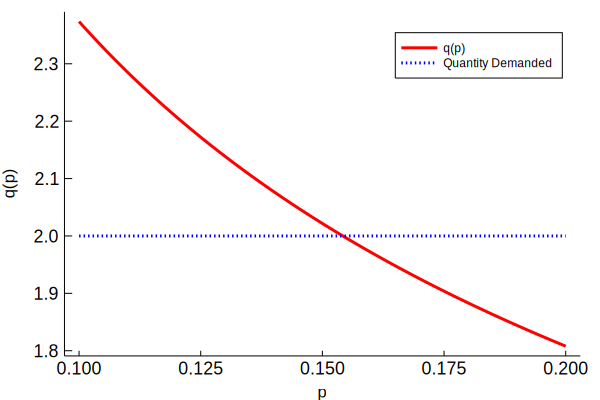

In [5]:
# plot the quantity as a function of price
plot(x, [y q_d],
    linestyle = [:solid :dot],
    linewidth = [3 3],
    linecolor = [:red :blue],
    grid = :false,
    tickfontsize = 12,
    xlabel = "p",
    ylabel = "q(p)",
    label = ["q(p)" "Quantity Demanded"])

Notice: if we let $t = p^{-0.1}$ then:

$q(t) = 0.5t^2 + 0.5t^5$

Can we solve for $t$ now?

No! Closed-form solutions to fifth order polynomials are not guaranteed to exist!

So how do we solve the problem?

# Newton's method
Iteratively do the following:
1. Guess solution to: $q(p) - q^* = 0 \rightarrow q(p) - 2 = 0$
2. Approximate the function with local  
second order polynomial around guess
3. Solve this easier equation
4. Solution is the new guess
5. Stop if previous guess and new guess are sufficiently close

In [6]:
p = .3        # initial guess
deltap = 1e10 # initialize stepsize
demand(p) = p^(-0.2)/2 + p^(-0.5)/2 - 2     # quantity minus price
demand_grad(p) = .1*p^(-1.2) + .25*p^(-1.5) # gradient

demand_grad (generic function with 1 method)

In [7]:
# iterate on Newton's method
while abs(deltap) > 1e-4
    deltap = demand(p)/demand_grad(p)
    p += deltap
    println("Intermediate guess of p = $(round(p,digits=3)).")
end
println("The solution is p = $(round(p,digits=3)).")

Intermediate guess of p = 0.068.
Intermediate guess of p = 0.115.
Intermediate guess of p = 0.147.
Intermediate guess of p = 0.154.
Intermediate guess of p = 0.154.
Intermediate guess of p = 0.154.
The solution is p = 0.154.


We will learn how and why this method works in a few classes

# Example 3

Consider a two period ag commodity market model

Period 1: Farmer makes acreage decisions for planting  
Period 2: Per-acre yield realizes, equilibrium crop price clears the market

The farmer's policy function is: $a(E[p]) = \frac{1}{2} + \frac{1}{2}E[p]$

After planting, yield $\hat{y}$ realizes, producing a total quantity $q = a\hat{y}$ of the crop

Demand is given by $p(q) = 3-2q$

Yield is given by $\hat{y} \sim \mathcal{N}(1,0.1)$

**How much acreage does the farmer plant?**

$p(\hat{y}) = 3-2a\hat{y}$

$a = \frac{1}{2} + \frac{1}{2}(3-2aE[\hat{y}])$

Rearrange and solve:

$a^* = 1$

Now suppose the government implements a price floor on the crop of $p > 1$ so we have that $p(\hat{y}) = \max(1,3-2a\hat{y})$

**How much acreage does the farmer plant?**

This is analytically intractable

The max operator is non-linear so we can't pass the expectation through

$E[\max(1,3-2a\hat{y})] \neq \max(1,E[3-2a\hat{y}])$

$\rightarrow$ we need to solve this numerically

In [8]:
# generate a scheme that allows us to approximate a continuous distribution
# with a discrete distribution (we will learn about this later)
y, weights = qnwnorm(12, 1, 0.1)

# solve the problem via function iteration (exploits fixed points)
a = 1.         # initial guess
p = 0.         # define price outside the loop (more later)
exp_price = 0.
diff = 100.    # initialize error

while diff > 1e-4
    a_old = a                      # save old acreage
    p = max.(1,3 .- 2 .*a.*y)      # compute price at all distribution points
    exp_price = (weights'*p)[1]    # compute expected price
    a = 1/2 + 1/2*exp_price        # get new acreage planted given new price
    diff = abs(a-a_old)            # change in acreage planted
    println("Intermediate acreage guess: $(round(a,digits=3))")
end

println("The optimal number of acres to plant is $(round(a,digits=3)).")
println("The expected price is $(round(exp_price,digits=3)).")

Intermediate acreage guess: 1.131
Intermediate acreage guess: 1.082
Intermediate acreage guess: 1.1
Intermediate acreage guess: 1.094
Intermediate acreage guess: 1.096
Intermediate acreage guess: 1.095
Intermediate acreage guess: 1.095
Intermediate acreage guess: 1.095
Intermediate acreage guess: 1.095
The optimal number of acres to plant is 1.095.
The expected price is 1.191.


# Big O Notation

How do we quantify **speed** and **accuracy** of computational algorithms?

i.e. what is the **computational complexity** of the problem?

**General mathematical definition:** Big O notation describes the limiting behavior of a function when the argument tends towards a particular value or infinity

**Programming context:** Describes the limiting behavior of algorithms in terms of run time/memory/accuracy as input size grows

You've seen this before in the expression of Taylor series' errors

# Big O Notation

Written as: **O(F(x))**

Here is how to think about it:

**O(x):** linear
- Time to solve increases linearly in input x
- Accuracy changes linearly in input x

**Examples?**

Time to find a particular (e.g. maximum) value in an unsorted array

$\rightarrow$ For each element, check whether it is the value we want

# Big O Notation

**O($\mathbf{c^n}$):** exponential
- Time to solve increases exponentially in input x
- Accuracy changes exponentially in input x

**Examples?**

Time to solve a standard dynamic program, ex traveling salesman

$\rightarrow$ For each city, solve a Bellman as a function of all other cities

# Big O Notation

**O($n!$):** factorial
- Time to solve increases factorially in input x
- Accuracy changes factorially in input x

**Examples?**

Solving traveling salesman by brute force

$\rightarrow$ Obtain travel time for all possible combinations of intermediate cities

# Big O Notation: Accuracy example

This is how you have probably seen Big O used before:

Taylor series for $sin(x)$ around zero:

$sin(x) \approx x - x^3/3! + x^5/5! + O(x^7)$

What does $O(x^7)$ mean here?

As we move away from $0$ to some $x$, the upper bound of the growth rate in the error of our approximation to $sin(x)$ is $x^7$

We are approximating about zero so $x$ is small and $x^n$ is decreasing in $n$

For small $x$, higher order polynomials mean the error will grow slower and we have a better local approximation

In [9]:
# Sin example, print relative errors

# sin(x) = 0, approximation is a polynomial without a constant so also zero
println("Error of fifth-order approximation at x=0 is: 0")

# fifth and third order Taylor approximations
sin_error_5(x) = sin(x) - (x - x^3/6 + x^5/120)
sin_error_3(x) = sin(x) - (x - x^3/6)


Error of fifth-order approximation at x=0 is: 0


sin_error_3 (generic function with 1 method)

In [10]:
x = .001
println("Error of fifth-order approximation at x = $x is: $(sin_error_5(x))")
println("Error of third-order approximation at x = $x is: $(sin_error_3(x))")

Error of fifth-order approximation at x = 0.001 is: 0.0
Error of third-order approximation at x = 0.001 is: 8.239936510889834e-18


In [11]:
x = .01
println("Error of fifth-order approximation at x = $x is: $(sin_error_5(x))")
println("Error of third-order approximation at x = $x is: $(sin_error_3(x))")

Error of fifth-order approximation at x = 0.01 is: -1.734723475976807e-18
Error of third-order approximation at x = 0.01 is: 8.333316675601665e-13


In [12]:
x = .1
println("Error of fifth-order approximation at x = $x is: $(sin_error_5(x))")
println("Error of third-order approximation at x = $x is: $(sin_error_3(x))")

Error of fifth-order approximation at x = 0.1 is: -1.983851971587569e-11
Error of third-order approximation at x = 0.1 is: 8.331349481138783e-8


# Big O Notation: Speed examples

Here are a few examples for fundamental computational methods

# Big O Notation: O(1)

**O(1):** algorithm executes in <font color=#3C93DC>**constant time**</font>

The size of the input does not affect execution speed

Example: accessing a specific location in an array

# Big O Notation: O(x)

**O(x):** algorithm executes in <font color=#3C93DC>**linear time**</font>

Execution speed grows linearly in input size

Example: inserting an element into an arbitrary location in a 1 dimensional array

Bigger array $\rightarrow$ need to shift around more elements in memory to accomodate the new element

# Big O Notation: O($x^2$)

**O(x):** algorithm executes in <font color=#3C93DC>**quadratic time**</font>

More generally called polynomial time for $x^n$

Execution speed grows quadratically in input size

Example: Two nested loops applying an operation to an array

One loop grows linearly, number of operations $=$ number of elements

Two loops grows quadratically, need to do one full loop of $x$ operations for each element

# What can we compute?

- Computable general equilibrium models
- Linear-quadratic models
- RBC models
- Rational expectations models
- Non-linear dynamic programs
- Dynamic games

We can use computation + theory to answer **quantitative** questions

Theory can't give us welfare in dollar terms

Theory often relies on strong assumptions like
- log utility (lose income vs substitution)
- no transactions costs (important friction)
- strictly concave objectives (natural phenomena don't follow this)

It can be unclear what the cost of these assumptions are

# Computer arithmetic

## Storage

**Question:** which numbers can be represented by a computer?

Before the answer, *how* are numbers physically represented by a computer?

**<div class="blue">Binary</div>**: a base 2 number system

Each digit can only take on 0 or 1

Base 10: each digit can take on 0-9

**Question:** which numbers can be represented by a computer?

**Answer:** a **<font color=#3C93DC>subset</font>** of the rational numbers

**Why?**

Computers have <font color=#3C93DC>**finite**</font> memory and hard disk space

This imposes a strict limitation on the storage of numbers

Numbers are stored as: $\pm mb^{\pm n}$

$m$ is the mantissa/significand  
$b$ is the base  
$n$ is the exponent

All three are integers

The significand typically gives the significant digits

The exponent scales the number up or down in magnitude

The size of numbers a computer can represent is limited by how much space is typically allocated for a real number

Space allocations are usually 64 bits: 53 for $m$ and 11 for $n$

In [13]:
# Get the type of the number
println(typeof(5.0))
println(typeof(5))

Float64
Int64


`Int64` means it is a <font color=#3C93DC>**integer**</font> with 64 bits of storage

`Float64` means it is a <font color=#3C93DC>**floating point number**</font> with 64 bits of storage

Floating point just means $b^{\pm n}$ can move the decimal point around in the significand

`Int64` and `Float64` are different, this will be important later

# Limitations on storage suggest three facts:

1. There exists a <font color=#3C93DC>**machine epsilon**</font> which denotes the smallest **relative** quantity representible by a computer

Machine epsilon is the smallest $\epsilon$ such that a machine can distinguish $1+\epsilon > 1 > 1-\epsilon$.

In [14]:
println("Machine epsilon is $(eps(Float64))")
println("Is 1 + ϵ/4 > 1? $(1 + eps(Float64)/4 > 1)")
println("Is 1 - ϵ/4 < 1? $(1 - eps(Float64)/4 < 1)")

Machine epsilon is 2.220446049250313e-16
Is 1 + ϵ/4 > 1? false
Is 1 - ϵ/4 < 1? false


In [15]:
println("The smallest representable number larger than 1.0 is $(nextfloat(1.0))")
println("The largest representable number smaller than 1.0 is $(prevfloat(1.0))")

The smallest representable number larger than 1.0 is 1.0000000000000002
The largest representable number smaller than 1.0 is 0.9999999999999999


Machine epsilon changes depending on the amount of storage allocated to floating point numbers

In [16]:
println("Machine epsilon is $(eps(Float32))")
println("Is 1 + ϵ/4 > 1? $(1 + eps(Float32)/4 > 1)")
println("Is 1 - ϵ/4 < 1? $(1 - eps(Float32)/4 < 1)")

Machine epsilon is 1.1920929e-7
Is 1 + ϵ/4 > 1? false
Is 1 - ϵ/4 < 1? false


This means theres a tradeoff between precision and storage requirements

# Limitations on storage suggest three facts:

2. There is a <font color=#3C93DC>**smallest representable number**</font>

It also depends on storage allocation

In [17]:
println("64 bit smallest float is $(floatmin(Float64))")
println("32 bit smallest float is $(floatmin(Float32))")
println("16 bit smallest float is $(floatmin(Float16))")

64 bit smallest float is 2.2250738585072014e-308
32 bit smallest float is 1.1754944e-38
16 bit smallest float is 6.104e-5


# Limitations on storage suggest three facts:
3. There is a <font color=#3C93DC>**largest representable number**</font>

It also depends on storage allocation

In [18]:
println("64 bit smallest float is $(floatmax(Float64))")
println("32 bit smallest float is $(floatmax(Float32))")
println("16 bit smallest float is $(floatmax(Float16))")

64 bit smallest float is 1.7976931348623157e308
32 bit smallest float is 3.4028235e38
16 bit smallest float is 6.55e4


We can overcome these issues (if they ever arise) with arbitrary precision arithmetic

In [19]:
println("The largest 64 bit integer is $(typemax(Int64))")
println("Trying to make it bigger is ...troublesome: $(typemax(Int64)+1)")
println("It loops us around the number line: $(typemin(Int64))")

The largest 64 bit integer is 9223372036854775807
Trying to make it bigger is ...troublesome: -9223372036854775808
It loops us around the number line: -9223372036854775808


In [20]:
println("With SCIENCE we can make it bigger: $(BigInt(typemax(Int64))*1000000)")

With SCIENCE we can make it bigger: 9223372036854775807000000


# Key thing to keep in mind

**<font color=#3C93DC>The scale of your problem matters</font>**

If a parameter or variable is > floatmax or < floatmin, **you will have a very bad time**

Scale numbers appropriately (e.g. millions of dollars, not millionths of cents)

# Computer arithmetic

## Error

We can only represent a finite number of numbers

This means we will have error in our computations

Error comes in two major forms:

1. Rounding
2. Truncation

# Rounding

We will always need to round numbers to the nearest computer representable number, this introduces error

In [21]:
println("Half of π is: $(π/2)")

Half of π is: 1.5707963267948966


The computer gave us a rational number, but $\pi/2$ should be irrational

# Truncation

Lots of important numbers are defined by infinite sums,

$e^x = \sum_{n=0}^\infty \frac{x^n}{n!}$

It turns out that computers can't add up infinitely many terms because there is finite space

$\rightarrow$ we need to truncate the sum

# Why does this matter?

Errors are small, who cares?

You should!

Because errors can propagate and grow as you keep applying an algorithm (e.g. function iteration)

# Error example 1

Consider a simple quadratic: $x^2-26x+1=0$

The solution is: $x = 13-\sqrt{168}$

In [22]:
println("Arbitrary precision: 13 - √168 = $(BigFloat(13-sqrt(168)))")
println("64 bit: 13 - √168 = $(13-sqrt(168))")
println("32 bit: 13 - √168 = $(convert(Float32,13-sqrt(168)))")
println("16 bit: 13 - √168 = $(convert(Float16,13-sqrt(168)))")

Arbitrary precision: 13 - √168 = 3.851860318427924312345567159354686737060546875e-02
64 bit: 13 - √168 = 0.03851860318427924
32 bit: 13 - √168 = 0.038518604
16 bit: 13 - √168 = 0.0385


# Error example 2

Lets add and subtract some numbers and play around with the associative property of real numbers:

- $x = (10^{-20} + 1) - 1$
- $y = 10^{-20} + (1 - 1)$

Very clearly we should get $x=y$, but do we? Let's find out

In [23]:
x = (1e-20 + 1) - 1   # initialize x
y = 1e-20 + (1 - 1)   # initialize y
x_equals_y = (x == y) # store boolean of whether x == y

if x_equals_y
    println("X equals Y!")
else
    println("X does not equal Y!")
    println("The difference is: $(x-y).")
end

X does not equal Y!
The difference is: -1.0e-20.


The two numbers were not equal, we got $y > x$

Why?

Adding numbers of greatly different magnitudes does not always work like you would want

In [24]:
x = (1e-20 + 1) - 1   # initialize x
y = 1e-20 + (1 - 1)   # initialize y
println("x is $x")
println("y is $y")

x is 0.0
y is 1.0e-20


When we added $10^{-20}$ to $1$, it got rounded away

# Error example 3

Lets just subtract two numbers: 100000.2 - 100000.1

We know the answer is: 0.1

In [25]:
println("100000.2 - 100000.1 is: $(100000.2 - 100000.1)")
if (100000.2 - 100000.1) == 0.1
    println("and it is equal to 0.1")
else
    println("and it is not equal to 0.1")
end

100000.2 - 100000.1 is: 0.09999999999126885
and it is not equal to 0.1


Why do we get this error?

Neither of the two numbers can be precisely represented by the machine!

$100000.1 \approx 8589935450993459\times 2^{-33} = 100000.0999999999767169356346130$  
$100000.2 \approx 8589936309986918\times 2^{-33} = 100000.1999999999534338712692261$

So their difference won't necessarily be 0.1

# Calculus operations
## Differentiation

# Differentiation

Derivatives are obviously important in economics for finding optimal allocations, etc

The formal definition of a derivative is:

$\frac{d f(x)}{dx} = \lim_{h\rightarrow 0} \frac{f(x+h)-f(x)}{h}$

But we can let $t = 1/h$ and reframe this as an infinite limit

$\frac{d f(x)}{dx} = \lim_{t\rightarrow \infty} \frac{f(x+1/t)-f(x)}{1/t}$

which we know a computer can't handle

# Computer differentiation

How do we perform derivatives on computers if we can't take the limit?

**<font color=#3C93DC>Finite difference methods</font>**

Idea: instead of letting $h\rightarrow 0$, approximate it by letting $h = $ a small number

What does a finite difference approximation look like?

# Forward difference
The forward difference looks exactly like the formal definition without the limit: $\frac{d f(x)}{dx} \approx \frac{f(x+h)-f(x)}{h}$

Works the same for partial derivatives: $\frac{\partial g(x,y)}{\partial x} \approx \frac{g(x+h,y)-g(x,y)}{h}$

Let's see how it works in practice by calculating derivatives of $x^2$ at $x=2$

In [26]:
deriv_x_squared(h,x) = ((x+h)^2 - x^2)/h # derivative function

deriv_x_squared (generic function with 1 method)

In [27]:
println("The deriviative with h=1e-8 is: $(deriv_x_squared(1e-8,2.))")

The deriviative with h=1e-8 is: 3.999999975690116


In [28]:
println("The deriviative with h=1e-12 is: $(deriv_x_squared(1e-12,2.))")

The deriviative with h=1e-12 is: 4.000355602329364


In [29]:
println("The deriviative with h=1e-30 is: $(deriv_x_squared(1e-30,2.))")

The deriviative with h=1e-30 is: 0.0


In [30]:
println("The deriviative with h=1e-1 is: $(deriv_x_squared(1e-1,2.))")

The deriviative with h=1e-1 is: 4.100000000000001


# Error, it's there

None of the values we chose for $h$ were perfect, but clearly some were better than others

We face two opposing forces:
1. We want $h$ to be as small as possible so that we can approximate the limit as well as we possibly can, BUT

2. If $h$ is small then $f(x+h)$ is close to $f(x)$, we can run into rounding issues like we saw for $h=10^{-30}$

We can select $h$ in an optimal fashion: $h = \max\{|x|,1\}\sqrt{\epsilon}$

# How much error is in a finite difference?

Can we measure the error growth rate in $h$?

Perform a first-order taylor expansion of $f(x)$ around $x$:

$f(x+h) = f(x) + f'(x)h + O(h^2)$

Recall $O(h^2)$ means the error in our approximation grows quadratically in $h$, we only did a linear approximation

How can we use this to understand the error in our finite difference approximation?

Rearrange to obtain: $f'(x) = \frac{f(x+h) - f(x)}{h} + O(h^2)/h$

# Forward differences have linearly growing errors

$f'(x) = \frac{f(x+h) - f(x)}{h} + O(h)$ because $O(h^2)/h = O(h)$

If we halve $h$, we halve the error in our approximation (ignoring rounding/truncation issues)

# Improvements on the forward difference

How can we improve the accuracy of the forward difference?

First, **why** do we have error?

Because we are approximating the slope of a tangent curve at $x$ by a secant curve passing through $(x,x+h)$

The secant curve has the average slope of $f(x)$ on $[x,x+h]$

We want the derivative at $x$, which is on the edge of $[x,x+h]$, how about we **center** $x$?

# Central differences

We can approximate $f'(x)$ in a slightly different way: $f'(x) \approx \frac{f(x+h)-f(x-h)}{2h}$

This leaves $x$ in the middle of the interval over which we are averaging the slope of $f(x)$

**Is this an improvement on forward differences?**

# How much error is in a central finite difference?

Lets do two second-order Taylor expansions:
- $f(x+h) = f(x) + f'(x)h + f''(x)h^2/2! + O(h^3)$
- $f(x-h) = f(x) + f'(x)(-h) + f''(x) (-h)^2/2! + O(h^3)$

Subtract the two expressions (note that $O(h^3) - O(h^3) = O(h^3)$) and then divide by $2h$ to get

# Central differences have quadratic errors
$f'(x) = \frac{f(x+h)-f(x-h)}{2h} + O(h^2)$

Error falls quadratically in $h$, if we halve $h$ we reduce error by 75%

Optimal selection of $h$ for central differences is $h = \max\{|x|,1\}\epsilon^{1/3}$

# Why use anything but central differences?

Suppose we're computing a Jacobian of a multidimensional function, why would we ever use forward differences instead of central differences?

# Accuracy vs time tradeoffs
For each central difference:

We need to compute $g(x_1-h,x_2,...)$ and $g(x_1+h,x_2,...)$ for each $x_i$

But for a forward difference we only need to compute $g(x_1,x_2,...)$ one and then $g(x_1+h,x_2,...)$ for each $x_i$

Forward differences saves on computing time and operations at the expense of accuracy

For high dimensional functions it may be worth the tradeoff

# Higher order finite differences
We can use these techniques to approximate higher order derivatives

For example, take two third order Taylor expansions

- $f(x+h) = f(x) + f'(x)h + f''(x)h^2/2! + f'''(x)h^3/3! + O(h^4)$
- $f(x-h) = f(x) + f'(x)(-h) + f''(x)(-h)^2/2! + f'''(x)(-h)^3/3! + O(h^4)$

Add the two expressions and then divide by $h^2$ to get

$f''(x) = \frac{f(x+h) - 2f(x) + f(x-h)}{h^2} + O(h^2)$

Second derivatives are important for calculating Hessians and checking maxima or minima

# Differentiation without error?
Finite differences put us in between two opposing forces on the size of $h$

Can we improve upon finite differences?

# Analytic derivatives
One way is to code up the actual derivative

In [31]:
deriv_x_squared(x) = 2x

deriv_x_squared (generic function with 2 methods)

In [32]:
println("The deriviative is: $(deriv_x_squared(2.))")

The deriviative is: 4.0


Exact solution!

# Automatic differentiation
Coding up analytic derivatives by hand for complex problems is not always great because

1. It can take A LOT of programmer time, more than it is worth
2. Humans are suseptible to error in coding or calculating the derivative mathematically

<img src="https://i.imgflip.com/2rk12c.jpg">

# Autodiff: let the computer do it
Think about this: any mathematical function you can code up is made up of simple arithmetic operations
- add, subtract, divide, multiply
- trig functions
- exponentials/logs
- etc

The closed form derivatives of these operations is not hard, it turns out your computer can do it and yield exact solutions

# Autodiff: let the computer do it
How? There are methods that basically apply a giant chain rule to your whole program,  
and break down the derivative into the (easy) component parts that another package knows how to handle

In [33]:
# the function, it needs to be written in a particular way because the autodiff package is dumb
# *(x,y) is the julia function way to do x*y, autodiff needs to be in terms of julia functions to work correctly ¯\_(ツ)_/¯
ff(x) = *(x[1],x[1]) # x^2

ff (generic function with 1 method)

In [34]:
x = [2.]                                    # location to evaluate: ff(x) = 2^2
g = x -> ForwardDiff.gradient(ff, x)        # g = ∇f
println("ff'(x) at $(x[1]) is: $(g(x)[1])") # display graident value

ff'(x) at 2.0 is: 4.0


<img src="https://www.reactiongifs.us/wp-content/uploads/2016/06/oh_yeah_macho_man.gif">

# Calculus operations
## Integration  (trickier than differentiation)

We integrate to do a lot of stuff in economics
- Expectations
- Add up a continuous measure of things

$\int_D f(x) dx$, $f:\mathcal{R}^n-\mathcal{R}$, $ D\subset\mathcal{R}^n$

# How to think about integrals and their approximations

Integrals are effectively infinite sums

1 dimensional example:

$\lim_{dx_i\rightarrow0}\sum_{i=0}^{(a-b)/dx_i} f(x_i) dx_i$

where $dx_i$ is some subset of $[a,b]$ and $x_i$ is some evaluation point (e.g. midpoint of $dx_i$)

# Infinite limits strike again

Just like derivatives, we face an infinite limit as $(a-b)/dx_i \rightarrow \infty$

We avoid this issue in the same way as derivatives, we replace the infinite sum with something we can handle: a weighted finite sum

We will loop back around to the usual Monte Carlo approaches after this

# Quadrature rules

We approximate integrals using a technique called **quadrature**

We will focus on two classes of quadrature for now:
1. Newton-Cotes (the kind you've seen before)
2. Gaussian (probably new)

# Newton-Cotes quadrature rules

Suppose we want to integrate a one dimensional function $f(x)$ over $[a,b]$

How would you do it?

One answer is to replace the function with something easy to integrate: **a piecewise polynomial**

Key things to define up front:
- $x_i = a + (i-1)/h$ for $i=1,2,...,n$ where $h = \frac{b-a}{n-1}$

$x_i$s are the **quadrature nodes** of the approximation scheme and divide the interval into $n-1$ equally spaced subintervals of length $h$

# Midpoint rule
Most basic Newton-Cotes method:
1. Split $[a,b]$ into intervals
2. Approximate the function in each subinterval by a constant equal to the function at the midpoint of the subinterval

$\int_{x_i}^{x_{i+1}} f(x) dx \approx hf(\frac{1}{2}(x_{i+1}+x_i))$

# Trapezoid rule
Increase complexity by 1 degree:
2. Approximate the function in each subinterval by a linear interpolation passing through $(x_i,f(x_i))$ and $(x_{i+1},f(x_{i+1}))$

$\int_{x_i}^{x_{i+1}} f(x) dx \approx \frac{h}{2}[f(x_i) + f(x_{i+1})]$

We can aggregate this up to: $\int_{a}^{b} f(x) dx \approx \sum_{i=1}^n w_i f(x_i)$  
where $w_1=w_n = h/2$ and $w_i = h$ otherwise

# How accurate is this rule?
Trapezoid rule is **$O(h^2)$ / first-order exact:** it can integrate any linear function exactly

# Simpsons rule
Increase complexity by 1 degree:
2. Let $n$ be odd, then approximate the function across a **pair** of subintervals by a quadratic interpolation passing through $(x_{2i-1},f(x_{2i-i}))$, $(x_{2i},f(x_{2i}))$, and $(x_{2i+1},f(x_{2i+1}))$

$\int_{x_i}^{x_{i+1}} f(x) dx \approx \frac{h}{3}[f(x_{2i-1}) + 4f(x_{2i}) + f(x_{2i+1})]$

We can aggregate this up to: $\int_{a}^{b} f(x) dx \approx \sum_{i=1}^n w_i f(x_i)$  
where $w_1=w_n = h/3$, otherwise and $w_i = 4h/3$ if $i$ is even and $w_i = 2h/3$ if $i$ is odd

# How accurate is this rule?
Trapezoid rule is **$O(h^4)$ / third-order exact:** it can integrate any cubic function exactly

That's weird! Why do we gain 2 orders of accuracy when increasing one order of approximation complexity?

1. The approximating piecewise quadratic is exact at the end points and midpoint of the conjoined two subintervals
2. Clearly the difference between a cubic $f(x)$ and the quadratic approximation in $[x_{2i-1},x_{2i+1}]$ is another cubic function
3. You can prove that this cubic function is **odd** with respect to the midpoint $\rightarrow$ integrating over the first subinterval cancels integrating over the second subinterval

# Gaussian quadrature rules

How did we pick the $x_i$ quadrature nodes for Newton-Cotes rules?

Evenly spaced, no real reason for doing so...

Gaussian quadrature selects these nodes more efficiently and relies on **weight functions** $w(x)$

# Gaussian quadrature rules

Gaussian rules try to **exactly integrate** some finite dimensional collection of functions (i.e. polynomials up to some degree)

For a given order of approximation $n$, the weights $w_1,...,w_n$ and nodes $x_1,...,x_n$ are chosen to satisfy $2n$ **moment matching conditions**:

$\int_I x^kw(x)dx = \sum_{i=1}^n w_i x^k_i$, for $k=0,...,2n-1$

where $I$ is the interval over which we are integrating and $w(x)$ is a given weight function

# Gaussian quadrature improves accuracy
The moment matching conditions pin down $w_i$s and $x_i$s so we can approximate an integral by a weighted sum of the function at the prescribed nodes

$\int_i f(x) w(x)dx \approx \sum_{i=1}^n w_i f(x_i)$

Gaussian rules are $2n-1$ order exact, we can exactly compute the integral of any polynomial order $2n-1$

But what do we pick for the weighting function $w(x)$?

# Gauss-Legendre
We can start out with a simple $w(x) = 1$

This can approximate the integral of any function arbitrarily well by increasing $n$

# Gauss-Laguerre
Sometimes we want to compute exponentially discounted sums like: $\int_I f(x) e^{-x} dx$

The weighting function $e^{-x}$ is Gauss-Laguerre quadrature

# Gauss-Hermite
Sometimes we want to take expectations of normally distributed variables: $\int_I f(x) e^{-x^2} dx$

There exist packages or look-up tables to get the prescribed weights and nodes for each of these schemes

# Gaussian quadrature takeaways

Gaussian quadrature effectively discretizes some distribution $p(x)$ into mass points (nodes) and probabilities (weights) for some other discrete distribution $\bar{p}(x)$

Given an approximation with $n$ mass points, $X$ and $\bar{X}$ have identical moments up to order $2n$, and as $n\rightarrow\infty$ we have a continuum of mass points and recover the continuous pdf

# Monte Carlo integration
Approximate an integral by relying on LLN and "randomly" sampling the integration domain

Can be effective for very high dimensional integrals

Very simple and intuitive

But, produces a random approximation

# Monte Carlo integration
Integrate $\xi = \int_0^1 f(x) dx$ by drawing $N$ uniform samples, $x_1,...,x_N$ over interval $[0,1]$

$\xi$ is equivalent to $E[f(x)]$ with respect to a uniform distribution, so estimating the integral is the same as estimating the expected value of $f(x)$

$\hat{\xi} = \frac{1}{N}\sum_{i=1}^N f(x_i)$

LLN gives us that the plim$_{N\rightarrow\infty} \hat{\xi} = \xi$

The variance of $\hat{\xi}$ is $\sigma^2_{\hat{\xi}} = var(\frac{1}{N}\sum_{i=1}^N f(x_i)) = \frac{1}{N^2} \sum_{i=1}^N var(f(X)) = \frac{1}{N}\sigma^2_{f(X)}$ 

So average error is $\frac{1}{\sqrt{N}}\sigma_{f(X)}$, note: **it's independent of dimension of x!!**

# Quasi-Monte Carlo
The previous crude MC method converged pretty slowly, $O(1/\sqrt{N})$, can we improve on this?

Yes!

Picking **low-discrepancy sequences** instead of random numbers improves convergence to (almost) $O(1/N)$

Low-discrepancy sequences like Halton, Sobol, etc, "look" random

<img src="http://commons.apache.org/proper/commons-math/images/userguide/low_discrepancy_sequences.png">

# Linear Algebra

Lots of computational problems break down into linear systems

Many non-linear models are linearized

How do we **actually** solve these systems inside the machine?

# L-U Factorization

If $A$ in $Ax=b$ is upper or lower triangular, we can solve for $x$ recursively via forward/backward substitution

Consider a lower triangular matrix

The first element is the only non-zero value in the first row so $x_1$ is easy to solve for

The equation in row 2 contains $x_2$ and the already solved for $x_1$ so we can easily solve for $x_2$ and then continue until we solve for all $x$s

# Forward substitution
Forward substitution gives us solutions

$x_i = \frac{1}{a_{ii}} \left( b_i - \sum_{j=1}^{i-1}a_{ij}x_j\right)$, for all $i$

Issue: we don't usually luck into an upper or lower triangular matrix

L-U factorization is an algorithm that decomposes $A$ into the product of lower and upper triangular matrices

# L-U Factorization has two steps
1. Factor $A$ into lower $L$ and upper $U$ triangular matrices using Gaussian elimination
  1. We can do this for any non-singular square matrix
2. Solve for $x$
  1. (LU)x = b
  2. Solve for $y: Ly = b$ using forward substitution
  3. Using the solved $y$, we know $Ux=y$ and can solve with backward substitution

# Why bother with this scheme?
Why not just numerically invert or use Cramer's rule?

**Speed**

L-U requires $\frac{n^3}{3+n^2}$ operations to solve an $n$x$n$ system

Numerically inverting $A$ requires $n^3+n^2$

Cramer's rule requires (n+1)!

For a 10x10 system this is: 430 vs 1100 vs 40 million operations

# Mechanics of factorizing

Gaussian elimination is where we use row operations
1. swapping rows
2. multiplying by non-zero scalars
3. add a scalar multiple of one row to another

to turn a matrix $(IA)$ into $(LU)$

# Numerical error blow up
Small errors can have big effects, for example:
\begin{align*}
	\begin{bmatrix}
	    -M^{-1} & 1 \\
		1 & 1
	\end{bmatrix} 
	\begin{bmatrix}
	    x_1\\
	    x_2
	\end{bmatrix} 
	=
	\begin{bmatrix}
	    1\\
	    2
	\end{bmatrix} 
\end{align*}
where $M$ is big

Lets use L-U Factorization to solve it:

\begin{align*}
	\begin{bmatrix}
	    -M^{-1} & 1 \\
		1 & 1
	\end{bmatrix} 
	=
	\begin{bmatrix}
	    1 & 0\\
	    0 & 1
	\end{bmatrix} 
	\begin{bmatrix}
	    -M^{-1} & 1 \\
		1 & 1
	\end{bmatrix}  
\end{align*}

Subtract $-M$ times the first row from the second

This yields the L-U factorization
\begin{align*}
		\begin{bmatrix}
	    1&  0 \\
		0 & 1
	\end{bmatrix}
	\begin{bmatrix}
	    -M^{-1} & 1 \\
		1 & 1
	\end{bmatrix} 
	=
	\begin{bmatrix}
	    1 & 0\\
	    -M & 1
	\end{bmatrix} 
	\begin{bmatrix}
	    -M^{-1} & 1\\
	    0 & M+1
	\end{bmatrix} 
\end{align*}

We can get closed-form solutions:
\begin{align*}
	\begin{bmatrix}
	    x_1\\
	    x_2
	\end{bmatrix} 
	=
	\begin{bmatrix}
	    M/(M+1)\\
	    (M+2)/(M+1)
	\end{bmatrix} 
\end{align*}

# Numerical issues
Both variables are approximately 1 for large $M$, but remember adding small numbers to big numbers causes problems numerically

Backwards substitution (when solving $Ux=y$ after we have solved $Ly=b$) first calculates $x_2$ since it goes backwards

If $M=10000000000000000000$, the computer will return $x_2$ is equal to precisely $1$, this isn't terribly wrong

When we then perform the second step of backwards substitution, we solve for $x_1=-M(1-x_2)=0$, this is **very** wrong

Large errors like this often occur because diagonal elements are very small

# Ill-conditioning
A matrix $A$ is said to be ill-conditioned if a small perturbation in $b$ yields a large change in $x$

One way to measure ill-conditioning in a matrix is the elasticity of the solution with respect to $b$,
\begin{gather*}
	\sup_{||\delta b || > 0} \frac{||\delta x|| / ||x||}{||\delta b|| / ||b||}
\end{gather*}
which yields the percent change in $x$ given a percentage point change in the magnitude of $b$

If this elasticity is large, then computer representations of the system of equations can lead to large errors due to rounding

Approximate the elasticity by computing the **condition number**
\begin{gather*}
	\kappa = ||A|| \cdot ||A^{-1}||
\end{gather*}

$\kappa$ gives the least upper bound of the elasticity  

$\kappa$ is always larger than one and a rule of thumb is that for every order of magnitude, a significant digit is lost in the computation of $x$

# Next up: Coding and Git